/usr/lib64/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/lib64/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


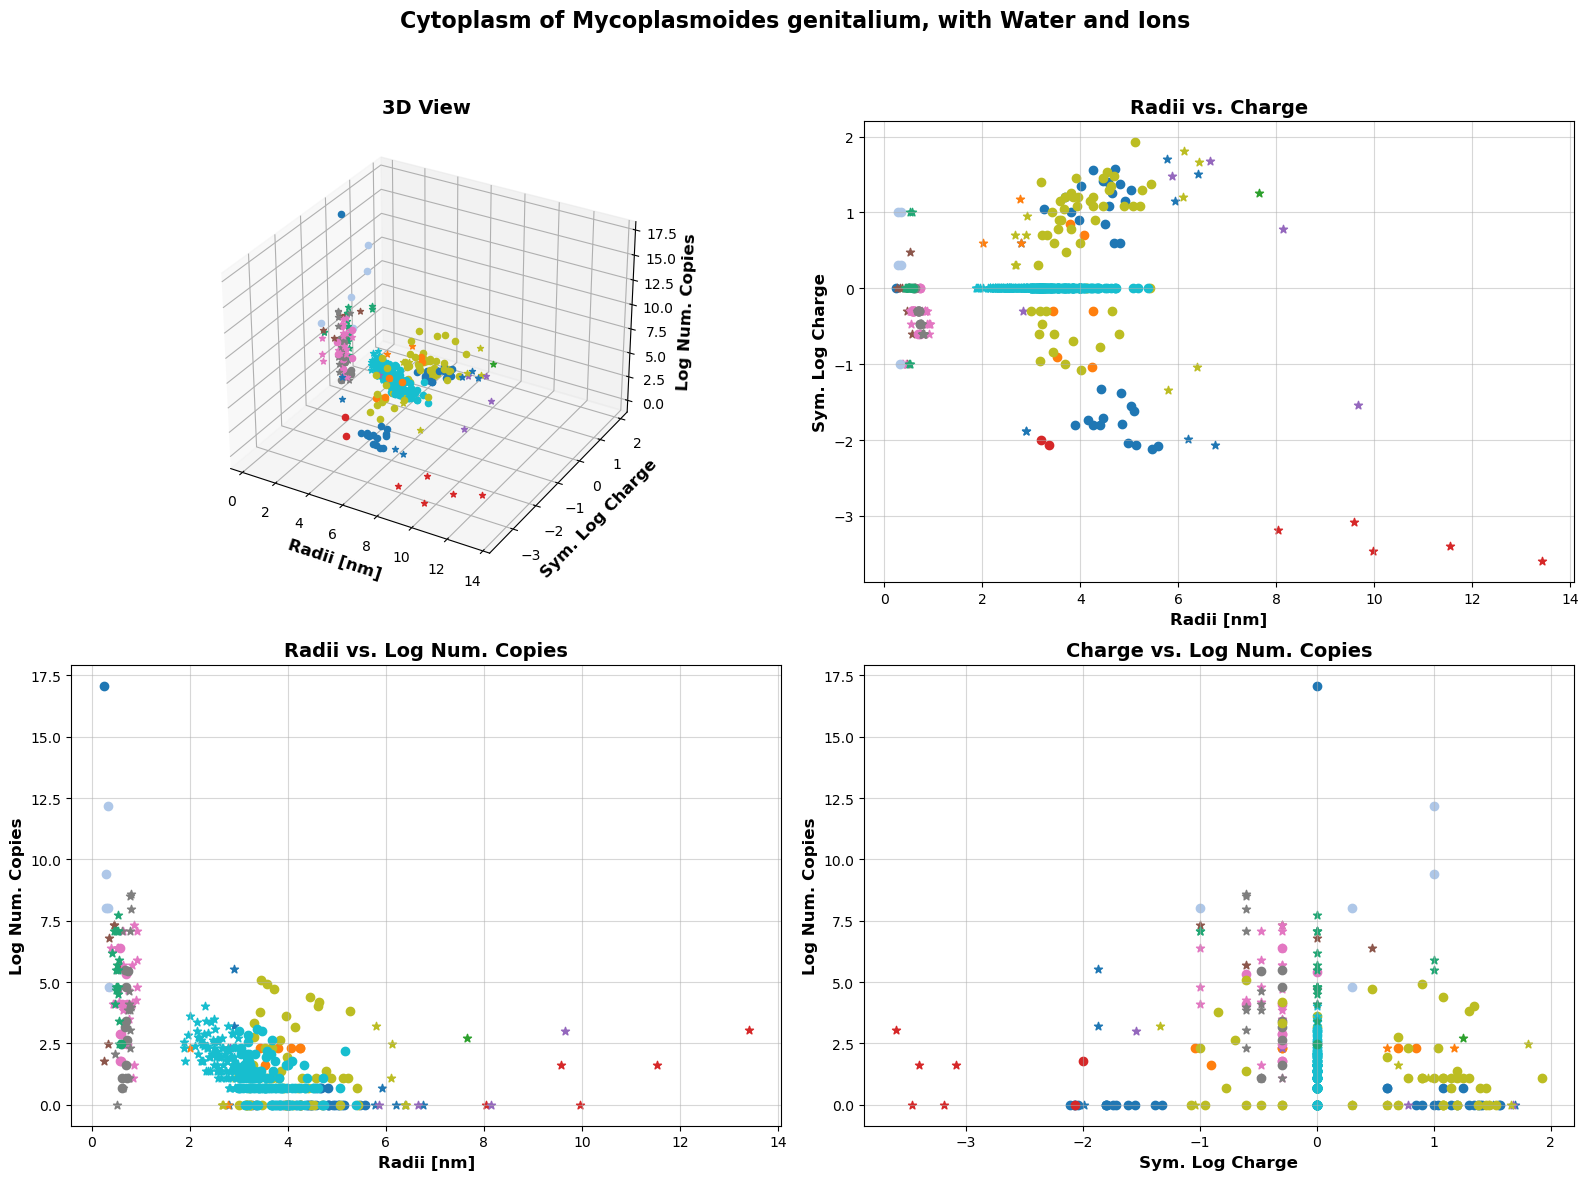

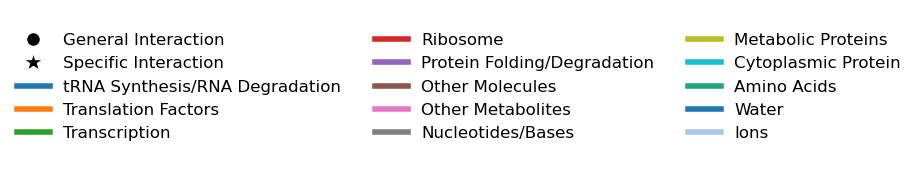

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Increase the font size and bold the text for titles and axis labels globally
plt.rcParams.update({
    'axes.titlesize': 15,  # Increase the font size of the title
    'axes.titleweight': 'bold',  # Bold the title font
    'axes.labelsize': 15,  # Increase the font size of the axis labels
    'axes.labelweight': 'bold',  # Bold the axis label font
    'grid.alpha': 0.5,  # Set grid line transparency
    'legend.fontsize': 12  # Set the legend font size
})

# Custom symmetric log function for charge transformation
def symlog(x, linthresh=1):
    is_negative = x < 0
    abs_x = np.abs(x)
    abs_x = np.where(x == 0, 0, np.where(abs_x < linthresh, linthresh, np.log10(abs_x)))
    return np.where(is_negative, -abs_x, abs_x)

# Manually assigned colors for each type of species
manual_color_map = {
    'tRNA Synthesis/RNA Degradation': '#1f77b4',
    'Translation Factors': '#ff7f0e',
    'Transcription': '#2ca02c',
    'Ribosome': '#d62728',
    'Protein Folding/Degradation': '#9467bd',
    'Other Molecules': '#8c564b',
    'Other Metabolites': '#e377c2',
    'Nucleotides/Bases': '#7f7f7f',
    'Metabolic Proteins': '#bcbd22',
    'Cytoplasmic Protein': '#17becf',
    'Amino Acids': '#1fa774',
    'Water': '#1f77b4',
    'Ions': '#aec7e8'
}

# Load the interaction matrix
interaction_matrix_path = "InteractionMatrix.csv"
interaction_df = pd.read_csv(interaction_matrix_path)

# Function to prepare data, assign colors and markers
def prepare_data(file_path):
    df = pd.read_excel(file_path)
    df['Marker'] = df['Name'].apply(lambda x: '*' if x in interaction_df.columns and (interaction_df[x] == 5).any() else 'o')
    df['Color'] = df['Tag'].apply(lambda x: manual_color_map.get(x, '#000000'))
    df['Radii'] = pd.to_numeric(df.iloc[:, 4], errors='coerce')
    df['ChargeTransformed'] = symlog(pd.to_numeric(df.iloc[:, 1], errors='coerce'))
    df['LogNCopies'] = np.log(pd.to_numeric(df.iloc[:, 3], errors='coerce'))
    return df

# Function to plot data and save the figures, including grid lines and formatted titles/labels
def plot_data(df, title, file_name_prefix):
    fig = plt.figure(figsize=(16, 12))
    ax1 = fig.add_subplot(221, projection='3d')
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    
    for _, row in df.iterrows():
        ax1.scatter(row['Radii'], row['ChargeTransformed'], row['LogNCopies'], color=row['Color'], marker=row['Marker'])
        ax2.scatter(row['Radii'], row['ChargeTransformed'], color=row['Color'], marker=row['Marker'])
        ax3.scatter(row['Radii'], row['LogNCopies'], color=row['Color'], marker=row['Marker'])
        ax4.scatter(row['ChargeTransformed'], row['LogNCopies'], color=row['Color'], marker=row['Marker'])

    # Set titles and labels with specific formatting
    for ax in [ax2, ax3, ax4]: # Enable grid for 2D plots
        ax.grid(True)

    # Adjust title and axis labels for all plots
    ax1.set_title('3D View', fontsize=14, fontweight='bold')
    ax2.set_title('Radii vs. Charge', fontsize=14, fontweight='bold')
    ax3.set_title('Radii vs. Log Num. Copies', fontsize=14, fontweight='bold')
    ax4.set_title('Charge vs. Log Num. Copies', fontsize=14, fontweight='bold')

    # Adjusting axis labels
    ax_labels = [
        ('Radii [nm]', 'Sym. Log Charge', 'Log Num. Copies'),
        ('Radii [nm]', 'Sym. Log Charge'),
        ('Radii [nm]', 'Log Num. Copies'),
        ('Sym. Log Charge', 'Log Num. Copies')
    ]
    
    for ax, labels in zip([ax1, ax2, ax3, ax4], ax_labels):
        ax.set_xlabel(labels[0], fontsize=12, fontweight='bold')
        ax.set_ylabel(labels[1], fontsize=12, fontweight='bold')
        if len(labels) == 3:
            ax.set_zlabel(labels[2], fontsize=12, fontweight='bold')

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit suptitle
    fig.savefig(f'{file_name_prefix}_plot.png')

    # Creating and saving a separate plot for the legend
    fig_legend, ax_legend = plt.subplots(figsize=(10, 2))
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='k', label='General Interaction', markersize=10),
                       plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='k', label='Specific Interaction', markersize=15)]
    for tag, color in manual_color_map.items():
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=tag))
    ax_legend.legend(handles=legend_elements, loc='center', ncol=3, frameon=False)
    ax_legend.axis('off')
    fig_legend.savefig(f'{file_name_prefix}_legend.png')
    plt.show()

# Prepare everything
df_with_ions = prepare_data("SpeciesList_Annotated.ods")
df_no_ions = prepare_data("SpeciesList-NoIons_Annotated.ods")

# Plot for Species With Ions (water_ions) and save
plot_data(df_with_ions, "Cytoplasm of Mycoplasmoides genitalium, with Water and Ions", "WithIons")

# Plot for Species Without Ions (NoWaterIons) and save
plot_data(df_no_ions, "Cytoplasm without Water and Ions", "NoIons")
